In [1]:
import pandas as pd
import geopandas as gpd
from shapely import wkt
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from scipy.spatial import distance_matrix
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn.functional as F
from torch_geometric.nn import GINConv, global_add_pool
from torch_geometric.utils import from_networkx
from statsmodels.stats.outliers_influence import variance_inflation_factor
import random
import itertools
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
# 加载数据对象
data = torch.load('data.pt')

In [3]:
best_params = {'lr': 0.005,
 'weight_decay': 0.001,
 'hidden1': 128,
 'hidden2': 64,
 'dropout': 0.3,
 'num_epochs': 200}

In [6]:
import torch
from torch_geometric.nn import GATv2Conv
# 定义GATv2模型
class GATv2(torch.nn.Module):
    def __init__(self, in_channels, hidden1, hidden2, out_channels, dropout):
        super(GATv2, self).__init__()
        self.conv1 = GATv2Conv(in_channels, hidden1, heads=1)
        self.bn1 = torch.nn.BatchNorm1d(hidden1)  # Batch normalization
        self.conv2 = GATv2Conv(hidden1, hidden2, heads=1)
        self.bn2 = torch.nn.BatchNorm1d(hidden2)  # Batch normalization
        self.fc1 = torch.nn.Linear(hidden2, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.bn1(x)  # Batch normalization
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)  # Dropout
        conv1_out = x  # 保存第一层卷积的输出
        x = self.conv2(x, edge_index)
        x = self.bn2(x)  # Batch normalization
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)  # Dropout
        conv2_out = x  # 保存第二层卷积的输出
        x = self.fc1(x)
        return conv1_out, conv2_out, x
# 假设 'data' 是一个预定义的 PyG 数据对象

# 包装模型，只返回最终的输出
class WrappedModel(torch.nn.Module):
    def __init__(self, model):
        super(WrappedModel, self).__init__()
        self.model = model

    def forward(self, x, edge_index):
        _, _, out = self.model(x, edge_index)
        return out

def train(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    _, _, out = model(data.x, data.edge_index)  # Unpack the tuple and use only the final output
    loss = F.mse_loss(out, data.y)
    loss.backward()
    optimizer.step()
    return loss.item()
    
model = GATv2(
    in_channels=data.x.shape[1], 
    hidden1=best_params['hidden1'], 
    hidden2=best_params['hidden2'], 
    out_channels=data.y.shape[1], 
    dropout=best_params['dropout']
)

# 方法1：加载整个模型
loaded_model = torch.load('good_explanation.pth')
wrapped_model = WrappedModel(loaded_model)
wrapped_model.eval()

WrappedModel(
  (model): GATv2(
    (conv1): GATv2Conv(64, 128, heads=1)
    (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): GATv2Conv(128, 64, heads=1)
    (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc1): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [54]:
# 保存模型
torch.save(model, 'good_explanation1.pth')
# 或者仅保存模型参数
torch.save(model.state_dict(), 'good_explanation_state_dict1.pth')

In [5]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

# 定义GATv2模型
class GATv2(torch.nn.Module):
    def __init__(self, in_channels, hidden1, hidden2, out_channels, dropout):
        super(GATv2, self).__init__()
        self.conv1 = GATv2Conv(in_channels, hidden1, heads=1)
        self.bn1 = torch.nn.BatchNorm1d(hidden1)  # Batch normalization
        self.conv2 = GATv2Conv(hidden1, hidden2, heads=1)
        self.bn2 = torch.nn.BatchNorm1d(hidden2)  # Batch normalization
        self.fc1 = torch.nn.Linear(hidden2, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = self.bn1(x)  # Batch normalization
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)  # Dropout
        conv1_out = x  # 保存第一层卷积的输出
        x = self.conv2(x, edge_index)
        x = self.bn2(x)  # Batch normalization
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)  # Dropout
        conv2_out = x  # 保存第二层卷积的输出
        x = self.fc1(x)
        return conv1_out, conv2_out, x

# 包装模型，只返回最终的输出
class WrappedModel(torch.nn.Module):
    def __init__(self, model):
        super(WrappedModel, self).__init__()
        self.model = model

    def forward(self, x, edge_index):
        _, _, out = self.model(x, edge_index)
        return out

def train(model, optimizer, data):
    model.train()
    optimizer.zero_grad()
    _, _, out = model(data.x, data.edge_index)  # Unpack the tuple and use only the final output
    loss = F.mse_loss(out, data.y)
    loss.backward()
    optimizer.step()
    return loss.item()

# Assuming 'data' is a pre-defined PyG data object
model = GATv2(
    in_channels=data.x.shape[1], 
    hidden1=best_params['hidden1'], 
    hidden2=best_params['hidden2'], 
    out_channels=data.y.shape[1], 
    dropout=best_params['dropout']
)
wrapped_model = WrappedModel(model)
optimizer = torch.optim.Adam(model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])

losses = []
for epoch in range(best_params['num_epochs']):
    loss = train(model, optimizer, data)
    losses.append(loss)

# 测试模型并计算评估指标
model.eval()
with torch.no_grad():
    _, _, pred = model(data.x, data.edge_index)  # Unpack the tuple and use only the final output
    residuals = data.y - pred

from torch_geometric.explain import Explainer, GNNExplainer
from tqdm import tqdm
wrapped_model.eval()

KeyboardInterrupt: 

In [7]:
import pandas as pd
import geopandas as gpd
from shapely import wkt
from torch_geometric.explain import Explainer, GNNExplainer
from tqdm import tqdm

# 读取CSV文件并创建GeoDataFrame
csv_file = 'LondonLSOAs.csv'
df = pd.read_csv(csv_file)

# 创建几何对象（假设geometry列包含WKT格式的多边形数据）
df['geometry'] = df['geometry'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(df, geometry='geometry')

# 设置坐标系 (假设是WGS84坐标系)
gdf.set_crs(epsg=27700, inplace=True)

# 提取Southwark区域的所有节点
southwark_nodes = gdf[gdf['LSOA21NM'].str.contains('Southwark 018B', case=False)]

# 打印这些节点的索引
print("Southwark nodes indices:", southwark_nodes.index.tolist())

Southwark nodes indices: [3795]


Generated explanations in ['edge_mask', 'node_mask']


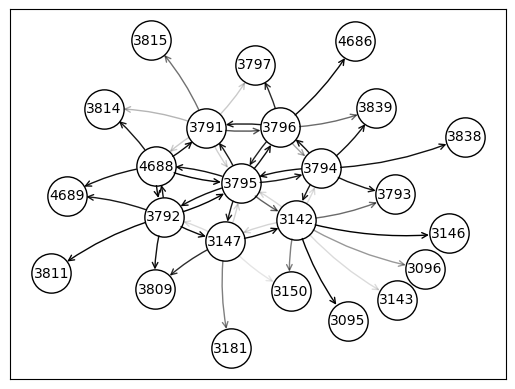

In [8]:
from torch_geometric.explain import Explainer, GNNExplainer
from tqdm import tqdm
for explanation_type in ['phenomenon']:
    explainer = Explainer(
        model=wrapped_model,
        algorithm=GNNExplainer(epochs=200),
        explanation_type=explanation_type,
        node_mask_type='object',
        edge_mask_type='object',
        model_config=dict(
            mode='regression',
            task_level='node',
            return_type='raw',
        ),
        # threshold_config=dict(threshold_type='hard', value=0.5) 
    )

# 选择一个节点进行解释（例如，节点0）
node_idx = 3795
explanation = explainer(data.x, data.edge_index, index=node_idx, target = data.y,)

# 输出解释结果
print(f'Generated explanations in {explanation.available_explanations}')

# 可视化特征重要性
# path = 'feature_importance.png'
# explanation.visualize_feature_importance(path, top_k=10)
# print(f"Feature importance plot has been saved to '{path}'")

# # 可视化子图
# path = 'subgraph.pdf'
# explanation.visualize_graph(path)
# print(f"Subgraph visualization plot has been saved to '{path}'")

# 获取子图节点索引
edge_mask = explanation.edge_mask > 0  # 使用掩码阈值
edge_index = data.edge_index[:, edge_mask]
node_indices = edge_index.unique().tolist()

explanation.visualize_graph()

Node: 0, value: 0.7603
Node: 1, value: 0.8098
Node: 2, value: 0.8524
Node: 3, value: 0.8596
Node: 875, value: 0.7746
Node: 877, value: 0.8536
Node: 878, value: 0.8310
Node: 2569, value: 0.8388
Node: 2570, value: 0.8300
Node: 2571, value: 0.8435
Node: 2589, value: 0.8463
Node: 4066, value: 0.7327
Node: 4078, value: 0.8492
Node: 4481, value: 0.7949
Node: 4536, value: 0.8425
Node: 4537, value: 0.8405
Node: 4600, value: 0.8911
Node: 4601, value: 0.8495
Node: 4636, value: 0.7916


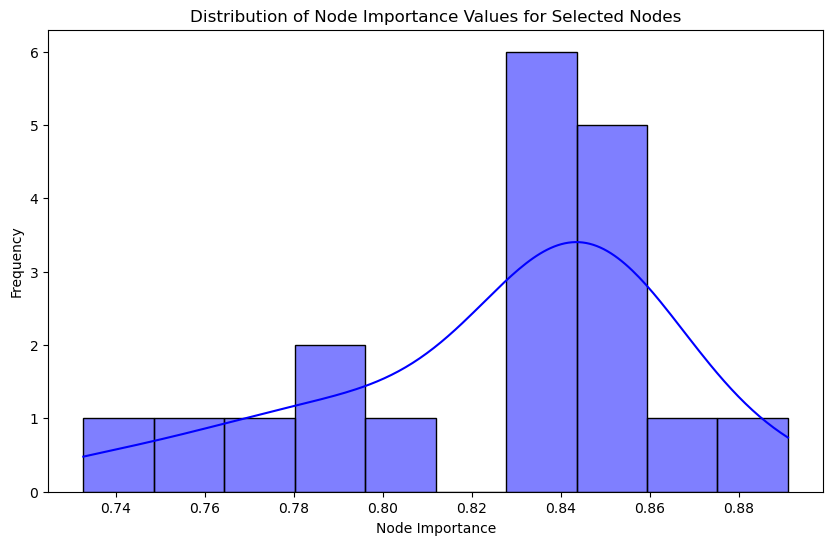

In [151]:
import matplotlib.pyplot as plt
import seaborn as sns

# 获取每个节点对应的 node_mask 值
node_mask_values = [explanation.node_mask[idx].item() for idx in node_indices]

# 打印所有索引和对应的 node_mask 值，并保留四位小数
for idx, mask_value in zip(node_indices, node_mask_values):
    print(f"Node: {idx}, value: {mask_value:.4f}")

# 创建一个新的绘图
plt.figure(figsize=(10, 6))

# 使用Seaborn绘制直方图和核密度估计图
sns.histplot(node_mask_values, kde=True, bins=10, color='blue', edgecolor='black')

# 添加标题和标签
plt.title('Distribution of Node Importance Values for Selected Nodes')
plt.xlabel('Node Importance')
plt.ylabel('Frequency')

# 显示图形
plt.show()


In [9]:
# 获取解释子图中的节点
node_indices = np.where(explanation.node_mask > 0)[0]
edge_indices = np.where(explanation.edge_mask > 0)[0]

# 获取节点的位置数据
node_positions = data.pos.numpy()

# 创建无向图
G = nx.Graph()

# 获取节点的重要性值
node_mask_values = {idx: explanation.node_mask[idx].item() for idx in node_indices}

# 添加解释子图中的节点和节点的重要性值作为属性
for idx in node_indices:
    value = explanation.node_mask[idx].item()
    lat, lon = node_positions[idx]
    G.add_node(int(idx), importance=value, pos=(lon, lat))

# 合成无向边并计算边的重要性
edge_importance = {}
for i in edge_indices:
    mask_value = explanation.edge_mask[i].item()
    source, target = data.edge_index[:, i]
    if source.item() in node_indices and target.item() in node_indices:  # 仅添加解释子图中的边
        if source.item() > target.item():  # 确保无向边的一致性
            source, target = target, source
        if (source.item(), target.item()) in edge_importance:
            edge_importance[(source.item(), target.item())].append(mask_value)
        else:
            edge_importance[(source.item(), target.item())] = [mask_value]

# 输出调试信息
print("Node indices:", node_indices)
print("Edge indices:", edge_indices)
print("Node positions:", {idx: (node_positions[idx][0], node_positions[idx][1]) for idx in node_indices})
print("Edge importance:", edge_importance)

# 计算每条无向边的重要性，对于只有一条有向边的情况直接使用该重要性值
edge_importance = {
    edge: np.mean(values) if len(values) > 1 else values[0] for edge, values in edge_importance.items()
}

# 添加边和边的重要性值作为属性
for (source, target), importance in edge_importance.items():
    G.add_edge(source, target, importance=importance)

# 获取节点位置
pos = nx.get_node_attributes(G, 'pos')

# 将节点位置转换为GeoDataFrame
geometry = [Point(lon, lat) for lat, lon in pos.values()]
node_importance = [G.nodes[node]['importance'] for node in G.nodes]
gdf = gpd.GeoDataFrame(list(pos.keys()), geometry=geometry, columns=['node'])
gdf['importance'] = node_importance

# 设置原始坐标系为EPSG:27700（英国国家格网）
gdf.set_crs(epsg=27700, inplace=True)
# 转换为WGS84坐标系（EPSG:4326）
gdf = gdf.to_crs(epsg=4326)
# 转换为墨卡托投影以匹配OpenStreetMap
gdf = gdf.to_crs(epsg=3857)

# 调试信息：检查转换后的坐标和边界框值
print("Converted coordinates:\n", gdf)
bounds = gdf.total_bounds  # 获取GeoDataFrame的边界框 [minx, miny, maxx, maxy]
print("Bounds:", bounds)

# 绘制图形
fig, ax = plt.subplots(figsize=(20, 20))

# 设置地图范围
if np.isfinite(bounds).all():
    x_buffer = (bounds[2] - bounds[0]) * 0.1
    y_buffer = (bounds[3] - bounds[1]) * 0.1
    ax.set_xlim([bounds[0] - x_buffer, bounds[2] + x_buffer])
    ax.set_ylim([bounds[1] - y_buffer, bounds[3] + y_buffer])
else:
    print("Invalid bounds detected, skipping axis limits setting")

# 添加OpenStreetMap底图
ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

# 绘制LSOA边界
London_lsoas_2021.boundary.plot(ax=ax, linewidth=1, edgecolor='black', zorder=2)

# 绘制GeoDataFrame并使用importance列作为颜色
gdf.plot(ax=ax, column='importance', cmap=plt.cm.coolwarm, markersize=600, edgecolor='black', zorder=5)

# 确保有边被添加到图中
if len(G.edges) > 0:
    # 绘制边，颜色和粗细根据重要性值进行调整
    for (source, target), importance in edge_importance.items():
        source_pos = gdf.loc[gdf['node'] == source, 'geometry'].values[0]
        target_pos = gdf.loc[gdf['node'] == target, 'geometry'].values[0]
        ax.plot([source_pos.x, target_pos.x], [source_pos.y, target_pos.y], 
                color=plt.cm.binary(importance), linewidth=14*importance, alpha=0.5, zorder=3)

    # 添加颜色条以显示边的重要性
    sm_edges = plt.cm.ScalarMappable(cmap=plt.cm.binary, norm=plt.Normalize(vmin=min(edge_importance.values()), vmax=max(edge_importance.values())))
    sm_edges._A = []
    plt.colorbar(sm_edges, ax=ax, label='Edge Importance')

# 添加节点的重要性颜色条
sm = plt.cm.ScalarMappable(cmap=plt.cm.coolwarm, norm=plt.Normalize(vmin=min(node_importance), vmax=max(node_importance)))
sm._A = []
plt.colorbar(sm, ax=ax, label='Node Importance')

# 添加节点标签
for node, (lat, lon) in pos.items():
    point = gpd.GeoSeries([Point(lon, lat)], crs="EPSG:27700").to_crs("EPSG:3857").geometry[0]
    ax.text(point.x, point.y, str(node), fontsize=12, ha='right', zorder=10, bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

plt.title("Node and Edge Importance in Graph with OpenStreetMap and LSOA Boundaries")
plt.show()

Node indices: [3095 3096 3142 3143 3146 3147 3150 3181 3791 3792 3793 3794 3795 3796
 3797 3809 3811 3814 3815 3838 3839 4686 4688 4689]
Edge indices: [18373 18379 18652 18655 18657 18660 18673 18679 18681 18683 18698 18701
 18876 22488 22490 22491 22492 22496 22497 22500 22502 22505 22509 22510
 22511 22512 22513 22514 22515 22516 22517 22518 22519 22520 22524 22525
 22598 22600 22610 22626 22630 22631 22765 22770 22771 27709 27725 27726
 27727 27730 27734]
Node positions: {3095: (536398.1960226609, 177825.95696899836), 3096: (535938.7157368561, 178328.77196694684), 3142: (535576.7458871459, 177962.28116589057), 3143: (536092.1612264474, 177691.53354317404), 3146: (536025.523931797, 177350.5188232196), 3147: (535382.0264673934, 177505.33511915168), 3150: (535623.6826735375, 177334.03209273276), 3181: (535505.0755016675, 176958.1648993345), 3791: (534410.5716169942, 177442.93072073313), 3792: (534905.1758997841, 177159.28475751964), 3793: (535226.1174528552, 178446.44798693142), 3794: 

NameError: name 'Point' is not defined

In [10]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx

# 读取LSOA的shapefile并转换坐标系
fp = 'LSOA_(Dec_2021)_Boundaries_Generalised_Clipped_EW_(BGC).shp'
London_lsoas_2021 = gpd.read_file(fp).rename(columns={'LSOA21CD':'geography code'})
London_lsoas_2021 = London_lsoas_2021[London_lsoas_2021["geography code"].str.startswith("E")]

# 设置原始坐标系为EPSG:27700（英国国家格网）
London_lsoas_2021.set_crs(epsg=27700, inplace=True)
# 转换为WGS84坐标系（EPSG:4326）
London_lsoas_2021 = London_lsoas_2021.to_crs(epsg=4326)
# 转换为墨卡托投影以匹配OpenStreetMap
London_lsoas_2021 = London_lsoas_2021.to_crs(epsg=3857)

Center node: 1832
Node indices: [1192 1761 1762 1763 1764 1765 1766 1767 1768 1796 1797 1829 1830 1831
 1832 1833 1834 1835 1840 1854 1860 2445 2448 2449 2450]
Direct neighbors: {1761, 1763, 1829, 1830, 1768, 1833, 1834, 2449}
Indirect neighbors: {1796, 1797, 2445, 2448, 2450, 1831, 1835, 1840, 1854, 1860, 1764, 1765, 1766, 1767}
WAD for center node 1832: 0.28374222790201503
Converted coordinates:
     node                        geometry  importance
0   1192  POINT (-27640.556 6711316.682)    0.441619
1   1761  POINT (-26416.040 6710512.833)    0.603622
2   1762  POINT (-28006.694 6710699.841)    0.559387
3   1763  POINT (-26782.980 6711127.821)    0.692097
4   1764  POINT (-27217.398 6711191.882)    0.401237
5   1765  POINT (-26095.702 6710854.520)    0.128678
6   1766  POINT (-26525.151 6710815.565)    0.142967
7   1767  POINT (-26827.497 6710864.610)    0.134009
8   1768  POINT (-27532.808 6710769.279)    0.595610
9   1796  POINT (-25812.754 6708726.658)    0.169231
10  1797  POINT

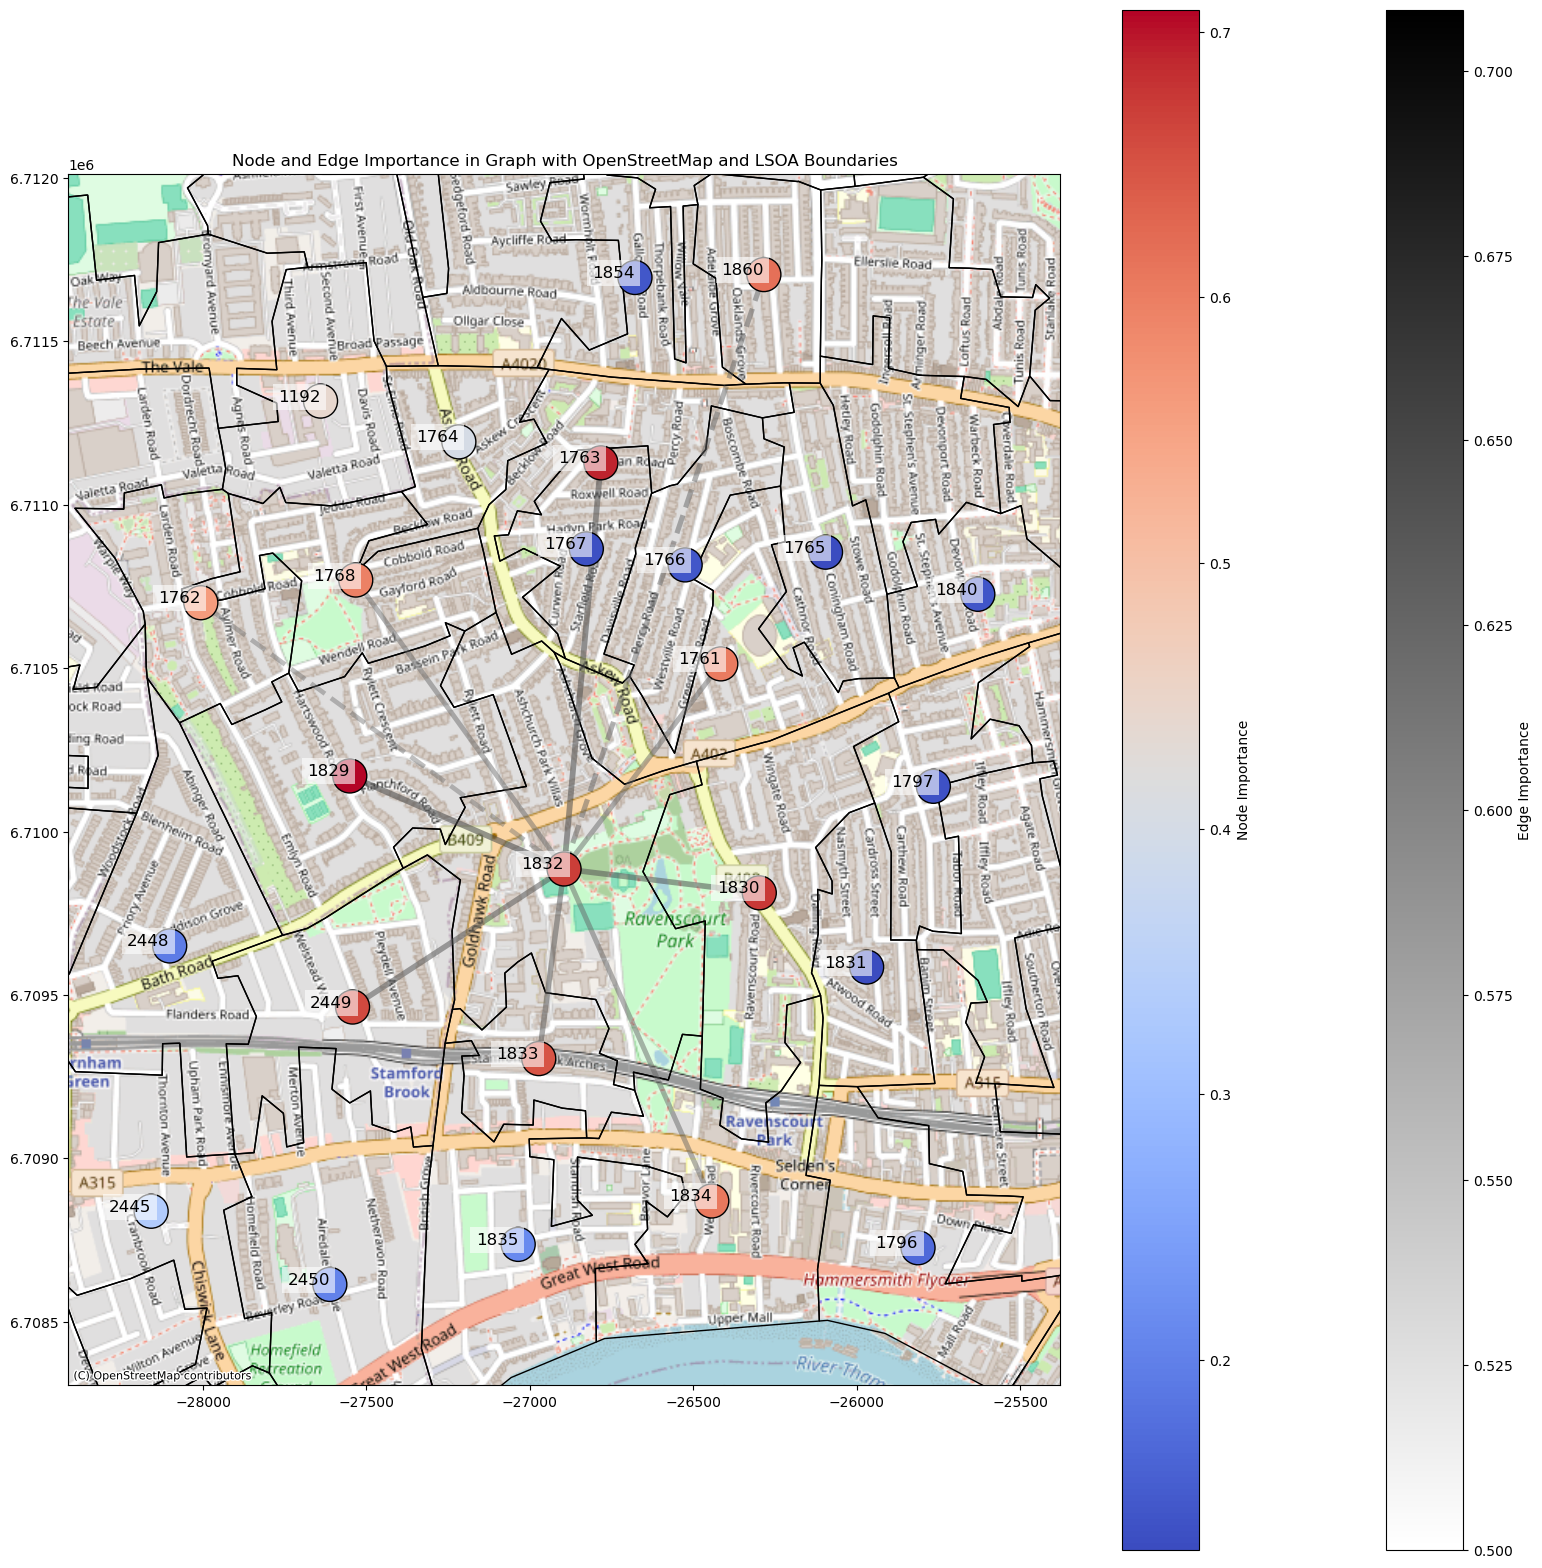

In [11]:
import numpy as np
import networkx as nx
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import contextily as ctx

# 假设研究中心节点为2428
center_node = 1832
threshold = 0.5

# 初始化直接邻居和间接邻居集合
direct_neighbors = set()
indirect_neighbors = set()

# 输出用于调试的信息
print(f"Center node: {center_node}")
print(f"Node indices: {node_indices}")

# 遍历 node_indices 找出直接邻居和间接邻居
for i in range(data.edge_index.shape[1]):
    source, target = data.edge_index[:, i]
    source, target = source.item(), target.item()
    if source in node_indices and target in node_indices:
        if source == center_node:
            direct_neighbors.add(target)
        elif target == center_node:
            direct_neighbors.add(source)
        elif source in direct_neighbors:
            indirect_neighbors.add(target)
        elif target in direct_neighbors:
            indirect_neighbors.add(source)

# 移除直接邻居中出现的间接邻居
indirect_neighbors -= direct_neighbors

# 输出直接邻居和间接邻居集合
print(f"Direct neighbors: {direct_neighbors}")
print(f"Indirect neighbors: {indirect_neighbors}")

# 构建新的边索引
new_edge_importance = {}
for node in node_indices:
    if node == center_node:
        continue
    importance = explanation.node_mask[node].item()
    new_edge_importance[(center_node, node)] = importance

# 计算WAD
edge_importances_for_wad = []
for (source, target), importance in new_edge_importance.items():
    if target in indirect_neighbors and importance < threshold:
        edge_importances_for_wad.append(0)  # 将重要性<threshold 的间接邻居边的值视为0
    else:
        edge_importances_for_wad.append(importance)

if edge_importances_for_wad:
    WAD = np.mean(edge_importances_for_wad)
else:
    WAD = 0

print(f"WAD for center node {center_node}: {WAD}")

# 创建无向图
G = nx.Graph()

# 添加节点和边到图中，并赋予默认的重要性值
for idx in node_indices:
    value = explanation.node_mask[idx].item()
    lat, lon = node_positions[idx]
    G.add_node(int(idx), importance=value, pos=(lon, lat))

for (source, target), importance in new_edge_importance.items():
    G.add_edge(source, target, importance=importance)

# 获取节点位置
pos = nx.get_node_attributes(G, 'pos')

# 将节点位置转换为GeoDataFrame
geometry = [Point(lon, lat) for lat, lon in pos.values()]
node_importance = [G.nodes[node]['importance'] for node in G.nodes]
gdf = gpd.GeoDataFrame(list(pos.keys()), geometry=geometry, columns=['node'])
gdf['importance'] = node_importance

# 设置原始坐标系为EPSG:27700（英国国家格网）
gdf.set_crs(epsg=27700, inplace=True)
# 转换为WGS84坐标系（EPSG:4326）
gdf = gdf.to_crs(epsg=4326)
# 转换为墨卡托投影以匹配OpenStreetMap
gdf = gdf.to_crs(epsg=3857)

# 调试信息：检查转换后的坐标和边界框值
print("Converted coordinates:\n", gdf)
bounds = gdf.total_bounds  # 获取GeoDataFrame的边界框 [minx, miny, maxx, maxy]
print("Bounds:", bounds)

# 绘制图形
fig, ax = plt.subplots(figsize=(20, 20))

# 设置地图范围
if np.isfinite(bounds).all():
    x_buffer = (bounds[2] - bounds[0]) * 0.1
    y_buffer = (bounds[3] - bounds[1]) * 0.1
    ax.set_xlim([bounds[0] - x_buffer, bounds[2] + x_buffer])
    ax.set_ylim([bounds[1] - y_buffer, bounds[3] + y_buffer])
else:
    print("Invalid bounds detected, skipping axis limits setting")

# 添加OpenStreetMap底图
ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

# 绘制LSOA边界
London_lsoas_2021.boundary.plot(ax=ax, linewidth=1, edgecolor='black', zorder=2)

# 绘制GeoDataFrame并使用importance列作为颜色
gdf.plot(ax=ax, column='importance', cmap=plt.cm.coolwarm, markersize=600, edgecolor='black', zorder=5)

# 确保有边被添加到图中
if len(G.edges) > 0:
    # 绘制边，颜色和粗细根据重要性值进行调整
    for (source, target), importance in new_edge_importance.items():
        source_pos = gdf.loc[gdf['node'] == source, 'geometry'].values[0]
        target_pos = gdf.loc[gdf['node'] == target, 'geometry'].values[0]
        linestyle = 'solid' if target in direct_neighbors or source in direct_neighbors else 'dashed'
        alpha = 0.8 if linestyle == 'solid' or importance > threshold else threshold
        if alpha > threshold:
            ax.plot([source_pos.x, target_pos.x], [source_pos.y, target_pos.y], 
                    color=plt.cm.binary(importance), linewidth= 6*importance, alpha=importance*0.8, linestyle=linestyle, zorder=3)

    # 添加颜色条以显示边的重要性
    sm_edges = plt.cm.ScalarMappable(cmap=plt.cm.binary, norm=plt.Normalize(vmin=threshold, vmax=max(new_edge_importance.values())))
    sm_edges._A = []
    plt.colorbar(sm_edges, ax=ax, label='Edge Importance')

# 添加节点的重要性颜色条
sm = plt.cm.ScalarMappable(cmap=plt.cm.coolwarm, norm=plt.Normalize(vmin=min(node_importance), vmax=max(node_importance)))
sm._A = []
plt.colorbar(sm, ax=ax, label='Node Importance')

# 添加节点标签
for node, (lat, lon) in pos.items():
    point = gpd.GeoSeries([Point(lon, lat)], crs="EPSG:27700").to_crs("EPSG:3857").geometry[0]
    ax.text(point.x, point.y, str(node), fontsize=12, ha='right', zorder=10, bbox=dict(facecolor='white', alpha=0.6, edgecolor='none'))

plt.title("Node and Edge Importance in Graph with OpenStreetMap and LSOA Boundaries")
plt.show()


In [216]:
# 打印 data.edge_index 用于调试
print(f"data.edge_index:\n{data.edge_index}")

# 找出直接相连的节点和间接相连的节点
direct_neighbors = set()
indirect_neighbors = set()

# 输出用于调试的信息
print(f"Center node: {center_node}")
print(f"Node indices: {node_indices}")
print(f"Edge indices: {edge_indices}")

data.edge_index:
tensor([[   0,    0,    0,  ..., 4993, 4993, 4993],
        [4537, 4536,    1,  ..., 4483, 4485, 4486]])
Center node: 1814
Node indices: [1773, 1782, 1783, 1785, 1786, 1787, 1810, 1811, 1813, 1814, 1815, 1816, 2703, 2704, 2705, 2706, 2750, 2751]
Edge indices: [25240 25283 25324 25328 25330 25332 25336 25339 25340 25342 25344 25346
 25350 25351 25352 25353 25354 25355 25356 25357 25359 25362 25490 25493
 25494 25497 25835 25947 25948 25953 25991 25992 28894 28897 28899 28908
 28909 28911 28917 28918 28919 28924 28926 28928]


In [30]:
import pandas as pd
import geopandas as gpd
from shapely import wkt
from torch_geometric.explain import Explainer, GNNExplainer
from tqdm import tqdm

# 读取CSV文件并创建GeoDataFrame
csv_file = 'LondonLSOAs.csv'
df = pd.read_csv(csv_file)

# 创建几何对象（假设geometry列包含WKT格式的多边形数据）
df['geometry'] = df['geometry'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(df, geometry='geometry')

# 设置坐标系 (假设是WGS84坐标系)
gdf.set_crs(epsg=27700, inplace=True)

# 提取Southwark区域的所有节点
southwark_nodes = gdf[gdf['LSOA21NM'].str.contains('Southwark', case=False)]

# 打印这些节点的索引
print("Southwark nodes indices:", southwark_nodes.index.tolist())

Southwark nodes indices: [3733, 3734, 3735, 3736, 3737, 3738, 3739, 3740, 3741, 3742, 3743, 3744, 3745, 3746, 3747, 3748, 3749, 3750, 3751, 3752, 3753, 3754, 3755, 3756, 3757, 3758, 3759, 3760, 3761, 3762, 3763, 3764, 3765, 3766, 3767, 3768, 3769, 3770, 3771, 3772, 3773, 3774, 3775, 3776, 3777, 3778, 3779, 3780, 3781, 3782, 3783, 3784, 3785, 3786, 3787, 3788, 3789, 3790, 3791, 3792, 3793, 3794, 3795, 3796, 3797, 3798, 3799, 3800, 3801, 3802, 3803, 3804, 3805, 3806, 3807, 3808, 3809, 3810, 3811, 3812, 3813, 3814, 3815, 3816, 3817, 3818, 3819, 3820, 3821, 3822, 3823, 3824, 3825, 3826, 3827, 3828, 3829, 3830, 3831, 3832, 3833, 3834, 3835, 3836, 3837, 3838, 3839, 3840, 3841, 3842, 3843, 3844, 3845, 3846, 3847, 3848, 3849, 3850, 3851, 3852, 3853, 3854, 3855, 3856, 3857, 3858, 3859, 3860, 3861, 3862, 3863, 3864, 3865, 3866, 3867, 3868, 3869, 3870, 3871, 3872, 3873, 3874, 3875, 3876, 4527, 4528, 4530, 4531, 4532, 4533, 4534, 4535, 4566, 4567, 4673, 4674, 4675, 4676, 4677, 4678, 4679, 4680, 46

In [31]:
southwark_nodes.shape

(173, 169)

In [13]:
# 假设已经通过解释器生成了explanation
explainer = Explainer(
    model=wrapped_model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='phenomenon',
    node_mask_type='object',
    edge_mask_type='object',
    model_config=dict(
        mode='regression',
        task_level='node',
        return_type='raw',
    ),
)

WAD_list = []
threshold = 0.5

# 遍历Southwark区域的节点，计算每个节点的WAD值
for center_node in tqdm(southwark_nodes.index):
    explanation = explainer(data.x, data.edge_index, index=center_node, target=data.y)
    
    edge_mask = explanation.edge_mask > 0  # 使用掩码阈值
    edge_index = data.edge_index[:, edge_mask]
    node_indices = edge_index.unique().tolist()

    direct_neighbors = set()
    indirect_neighbors = set()

    # 找出直接邻居和间接邻居
    for i in range(data.edge_index.shape[1]):
        source, target = data.edge_index[:, i]
        source, target = source.item(), target.item()
        if source in node_indices and target in node_indices:
            if source == center_node:
                direct_neighbors.add(target)
            elif target == center_node:
                direct_neighbors.add(source)
            elif source in direct_neighbors:
                indirect_neighbors.add(target)
            elif target in direct_neighbors:
                indirect_neighbors.add(source)

    # 移除直接邻居中出现的间接邻居
    indirect_neighbors -= direct_neighbors

    # 构建新的边索引
    new_edge_importance = {}
    for node in node_indices:
        if node == center_node:
            continue
        importance = explanation.node_mask[node].item()
        new_edge_importance[(center_node, node)] = importance

    # 计算WAD
    edge_importances_for_wad = []
    for (source, target), importance in new_edge_importance.items():
        if target in indirect_neighbors and importance < threshold:
            edge_importances_for_wad.append(0)  # 将重要性<threshold 的间接邻居边的值视为0
        else:
            edge_importances_for_wad.append(importance)

    if edge_importances_for_wad:
        WAD = np.mean(edge_importances_for_wad)
    else:
        WAD = 0

    WAD_list.append((center_node, WAD))
    print(f"WAD for center node {center_node}: {WAD}")

# 输出所有Southwark区域节点的WAD值
print("WAD values for Southwark nodes:", WAD_list)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:20<00:00, 20.44s/it]

WAD for center node 3795: 0.8089917846347975
WAD values for Southwark nodes: [(3795, 0.8089917846347975)]


In [32]:
# 比值法
import numpy as np

WAD_list = []
threshold = 0.5

# 遍历Southwark区域的节点，计算每个节点的WAD值
for center_node in tqdm(southwark_nodes.index):
    explanation = explainer(data.x, data.edge_index, index=center_node, target=data.y)
    
    edge_mask = explanation.edge_mask > 0  # 使用掩码阈值
    edge_index = data.edge_index[:, edge_mask]
    node_indices = edge_index.unique().tolist()

    direct_neighbors = set()
    indirect_neighbors = set()

    # 找出直接邻居和间接邻居
    for i in range(data.edge_index.shape[1]):
        source, target = data.edge_index[:, i]
        source, target = source.item(), target.item()
        if source in node_indices and target in node_indices:
            if source == center_node:
                direct_neighbors.add(target)
            elif target == center_node:
                direct_neighbors.add(source)
            elif source in direct_neighbors:
                indirect_neighbors.add(target)
            elif target in direct_neighbors:
                indirect_neighbors.add(source)

    # 移除直接邻居中出现的间接邻居
    indirect_neighbors -= direct_neighbors

    # 计算WAD
    important_neighbors_count = 0
    total_neighbors_count = 0

    for node in node_indices:
        if node == center_node:
            continue

        importance = explanation.node_mask[node].item()
        total_neighbors_count += 1

        if importance > threshold:
            important_neighbors_count += 1

    # 计算WAD为重要性>threshold的节点数量与所有邻居数量的比值
    if total_neighbors_count > 0:
        WAD = important_neighbors_count / total_neighbors_count
    else:
        WAD = 0

    WAD_list.append((center_node, WAD))
    print(f"WAD for center node {center_node}: {WAD}")

# 输出所有Southwark区域节点的WAD值
print("WAD values for Southwark nodes:", WAD_list)


  1%|▍                                                                                 | 1/173 [00:20<57:29, 20.05s/it]

WAD for center node 3733: 0.8125


  1%|▉                                                                                 | 2/173 [00:40<57:22, 20.13s/it]

WAD for center node 3734: 1.0


  2%|█▍                                                                                | 3/173 [01:00<56:59, 20.12s/it]

WAD for center node 3735: 0.9545454545454546


  2%|█▉                                                                                | 4/173 [01:20<56:39, 20.12s/it]

WAD for center node 3736: 0.8333333333333334


  3%|██▎                                                                               | 5/173 [01:40<56:15, 20.09s/it]

WAD for center node 3737: 1.0


  3%|██▊                                                                               | 6/173 [02:00<55:58, 20.11s/it]

WAD for center node 3738: 0.75


  4%|███▎                                                                              | 7/173 [02:20<55:34, 20.09s/it]

WAD for center node 3739: 0.8421052631578947


  5%|███▊                                                                              | 8/173 [02:40<55:20, 20.12s/it]

WAD for center node 3740: 0.9444444444444444


  5%|████▎                                                                             | 9/173 [03:01<55:00, 20.13s/it]

WAD for center node 3741: 0.9090909090909091


  6%|████▋                                                                            | 10/173 [03:21<54:39, 20.12s/it]

WAD for center node 3742: 0.9047619047619048


  6%|█████▏                                                                           | 11/173 [03:41<54:20, 20.13s/it]

WAD for center node 3743: 0.9473684210526315


  7%|█████▌                                                                           | 12/173 [04:01<54:05, 20.16s/it]

WAD for center node 3744: 0.9473684210526315


  8%|██████                                                                           | 13/173 [04:21<53:40, 20.13s/it]

WAD for center node 3745: 0.7647058823529411


  8%|██████▌                                                                          | 14/173 [04:41<53:14, 20.09s/it]

WAD for center node 3746: 0.9523809523809523


  9%|███████                                                                          | 15/173 [05:01<52:49, 20.06s/it]

WAD for center node 3747: 1.0


  9%|███████▍                                                                         | 16/173 [05:21<52:25, 20.04s/it]

WAD for center node 3748: 0.9047619047619048


 10%|███████▉                                                                         | 17/173 [05:41<52:02, 20.02s/it]

WAD for center node 3749: 1.0


 10%|████████▍                                                                        | 18/173 [06:01<51:39, 20.00s/it]

WAD for center node 3750: 0.6428571428571429


 11%|████████▉                                                                        | 19/173 [06:21<51:18, 19.99s/it]

WAD for center node 3751: 0.043478260869565216


 12%|█████████▎                                                                       | 20/173 [06:41<50:55, 19.97s/it]

WAD for center node 3752: 0.6071428571428571


 12%|█████████▊                                                                       | 21/173 [07:01<50:35, 19.97s/it]

WAD for center node 3753: 1.0


 13%|██████████▎                                                                      | 22/173 [07:21<50:15, 19.97s/it]

WAD for center node 3754: 1.0


 13%|██████████▊                                                                      | 23/173 [07:41<49:55, 19.97s/it]

WAD for center node 3755: 0.9333333333333333


 14%|███████████▏                                                                     | 24/173 [08:01<49:36, 19.97s/it]

WAD for center node 3756: 0.0


 14%|███████████▋                                                                     | 25/173 [08:21<49:19, 20.00s/it]

WAD for center node 3757: 0.07142857142857142


 15%|████████████▏                                                                    | 26/173 [08:41<49:01, 20.01s/it]

WAD for center node 3758: 0.7647058823529411


 16%|████████████▋                                                                    | 27/173 [09:01<48:41, 20.01s/it]

WAD for center node 3759: 0.0


 16%|█████████████                                                                    | 28/173 [09:21<48:20, 20.00s/it]

WAD for center node 3760: 0.0


 17%|█████████████▌                                                                   | 29/173 [09:41<48:04, 20.03s/it]

WAD for center node 3761: 0.8571428571428571


 17%|██████████████                                                                   | 30/173 [10:01<47:44, 20.03s/it]

WAD for center node 3762: 0.058823529411764705


 18%|██████████████▌                                                                  | 31/173 [10:21<47:23, 20.02s/it]

WAD for center node 3763: 0.03225806451612903


 18%|██████████████▉                                                                  | 32/173 [10:41<47:03, 20.03s/it]

WAD for center node 3764: 0.5555555555555556


 19%|███████████████▍                                                                 | 33/173 [11:01<46:42, 20.02s/it]

WAD for center node 3765: 0.375


 20%|███████████████▉                                                                 | 34/173 [11:21<46:22, 20.02s/it]

WAD for center node 3766: 0.5185185185185185


 20%|████████████████▍                                                                | 35/173 [11:41<46:01, 20.01s/it]

WAD for center node 3767: 0.0


 21%|████████████████▊                                                                | 36/173 [12:01<45:42, 20.02s/it]

WAD for center node 3768: 0.07407407407407407


 21%|█████████████████▎                                                               | 37/173 [12:21<45:19, 20.00s/it]

WAD for center node 3769: 0.3888888888888889


 22%|█████████████████▊                                                               | 38/173 [12:41<44:59, 20.00s/it]

WAD for center node 3770: 0.0


 23%|██████████████████▎                                                              | 39/173 [13:01<44:39, 19.99s/it]

WAD for center node 3771: 0.36363636363636365


 23%|██████████████████▋                                                              | 40/173 [13:21<44:18, 19.99s/it]

WAD for center node 3772: 0.0


 24%|███████████████████▏                                                             | 41/173 [13:41<43:57, 19.98s/it]

WAD for center node 3773: 0.05555555555555555


 24%|███████████████████▋                                                             | 42/173 [14:01<43:38, 19.99s/it]

WAD for center node 3774: 0.0


 25%|████████████████████▏                                                            | 43/173 [14:21<43:19, 20.00s/it]

WAD for center node 3775: 0.0


 25%|████████████████████▌                                                            | 44/173 [14:41<43:05, 20.05s/it]

WAD for center node 3776: 0.11764705882352941


 26%|█████████████████████                                                            | 45/173 [15:01<42:43, 20.03s/it]

WAD for center node 3777: 1.0


 27%|█████████████████████▌                                                           | 46/173 [15:21<42:22, 20.02s/it]

WAD for center node 3778: 1.0


 27%|██████████████████████                                                           | 47/173 [15:41<42:01, 20.02s/it]

WAD for center node 3779: 1.0


 28%|██████████████████████▍                                                          | 48/173 [16:01<41:38, 19.99s/it]

WAD for center node 3780: 1.0


 28%|██████████████████████▉                                                          | 49/173 [16:21<41:17, 19.98s/it]

WAD for center node 3781: 0.7666666666666667


 29%|███████████████████████▍                                                         | 50/173 [16:41<40:53, 19.95s/it]

WAD for center node 3782: 1.0


 29%|███████████████████████▉                                                         | 51/173 [17:01<40:31, 19.93s/it]

WAD for center node 3783: 1.0


 30%|████████████████████████▎                                                        | 52/173 [17:21<40:13, 19.94s/it]

WAD for center node 3784: 0.9583333333333334


 31%|████████████████████████▊                                                        | 53/173 [17:41<39:54, 19.96s/it]

WAD for center node 3785: 0.8571428571428571


 31%|█████████████████████████▎                                                       | 54/173 [18:01<39:37, 19.98s/it]

WAD for center node 3786: 0.7619047619047619


 32%|█████████████████████████▊                                                       | 55/173 [18:21<39:24, 20.03s/it]

WAD for center node 3787: 0.95


 32%|██████████████████████████▏                                                      | 56/173 [18:41<39:05, 20.04s/it]

WAD for center node 3788: 0.8095238095238095


 33%|██████████████████████████▋                                                      | 57/173 [19:01<38:48, 20.08s/it]

WAD for center node 3789: 0.84


 34%|███████████████████████████▏                                                     | 58/173 [19:21<38:28, 20.08s/it]

WAD for center node 3790: 0.125


 34%|███████████████████████████▌                                                     | 59/173 [19:41<38:07, 20.06s/it]

WAD for center node 3791: 0.8333333333333334


 35%|████████████████████████████                                                     | 60/173 [20:01<37:45, 20.05s/it]

WAD for center node 3792: 1.0


 35%|████████████████████████████▌                                                    | 61/173 [20:21<37:25, 20.05s/it]

WAD for center node 3793: 0.7272727272727273


 36%|█████████████████████████████                                                    | 62/173 [20:41<37:04, 20.04s/it]

WAD for center node 3794: 0.84


 36%|█████████████████████████████▍                                                   | 63/173 [21:01<36:42, 20.03s/it]

WAD for center node 3795: 0.9130434782608695


 37%|█████████████████████████████▉                                                   | 64/173 [21:21<36:23, 20.04s/it]

WAD for center node 3796: 1.0


 38%|██████████████████████████████▍                                                  | 65/173 [21:41<36:03, 20.04s/it]

WAD for center node 3797: 0.7272727272727273


 38%|██████████████████████████████▉                                                  | 66/173 [22:01<35:43, 20.03s/it]

WAD for center node 3798: 0.85


 39%|███████████████████████████████▎                                                 | 67/173 [22:21<35:22, 20.02s/it]

WAD for center node 3799: 0.5555555555555556


 39%|███████████████████████████████▊                                                 | 68/173 [22:41<35:02, 20.02s/it]

WAD for center node 3800: 0.6956521739130435


 40%|████████████████████████████████▎                                                | 69/173 [23:02<34:57, 20.17s/it]

WAD for center node 3801: 0.43333333333333335


 40%|████████████████████████████████▊                                                | 70/173 [23:22<34:41, 20.21s/it]

WAD for center node 3802: 0.8095238095238095


 41%|█████████████████████████████████▏                                               | 71/173 [23:43<34:22, 20.22s/it]

WAD for center node 3803: 0.42105263157894735


 42%|█████████████████████████████████▋                                               | 72/173 [24:03<33:57, 20.17s/it]

WAD for center node 3804: 0.9615384615384616


 42%|██████████████████████████████████▏                                              | 73/173 [24:23<33:38, 20.18s/it]

WAD for center node 3805: 0.5555555555555556


 43%|██████████████████████████████████▋                                              | 74/173 [24:43<33:14, 20.14s/it]

WAD for center node 3806: 0.6


 43%|███████████████████████████████████                                              | 75/173 [25:03<32:50, 20.11s/it]

WAD for center node 3807: 0.45


 44%|███████████████████████████████████▌                                             | 76/173 [25:23<32:36, 20.17s/it]

WAD for center node 3808: 0.625


 45%|████████████████████████████████████                                             | 77/173 [25:44<32:28, 20.30s/it]

WAD for center node 3809: 1.0


 45%|████████████████████████████████████▌                                            | 78/173 [26:04<32:02, 20.24s/it]

WAD for center node 3810: 0.6842105263157895


 46%|████████████████████████████████████▉                                            | 79/173 [26:24<31:36, 20.17s/it]

WAD for center node 3811: 0.9523809523809523


 46%|█████████████████████████████████████▍                                           | 80/173 [26:44<31:11, 20.12s/it]

WAD for center node 3812: 0.2


 47%|█████████████████████████████████████▉                                           | 81/173 [27:04<30:47, 20.08s/it]

WAD for center node 3813: 0.7142857142857143


 47%|██████████████████████████████████████▍                                          | 82/173 [27:24<30:27, 20.09s/it]

WAD for center node 3814: 1.0


 48%|██████████████████████████████████████▊                                          | 83/173 [27:44<30:09, 20.11s/it]

WAD for center node 3815: 0.85


 49%|███████████████████████████████████████▎                                         | 84/173 [28:04<29:46, 20.07s/it]

WAD for center node 3816: 0.7058823529411765


 49%|███████████████████████████████████████▊                                         | 85/173 [28:24<29:24, 20.05s/it]

WAD for center node 3817: 0.896551724137931


 50%|████████████████████████████████████████▎                                        | 86/173 [28:44<29:03, 20.04s/it]

WAD for center node 3818: 0.375


 50%|████████████████████████████████████████▋                                        | 87/173 [29:04<28:42, 20.03s/it]

WAD for center node 3819: 0.8947368421052632


 51%|█████████████████████████████████████████▏                                       | 88/173 [29:24<28:22, 20.03s/it]

WAD for center node 3820: 0.17391304347826086


 51%|█████████████████████████████████████████▋                                       | 89/173 [29:44<28:06, 20.07s/it]

WAD for center node 3821: 0.19047619047619047


 52%|██████████████████████████████████████████▏                                      | 90/173 [30:04<27:48, 20.10s/it]

WAD for center node 3822: 0.0


 53%|██████████████████████████████████████████▌                                      | 91/173 [30:25<27:27, 20.10s/it]

WAD for center node 3823: 0.0


 53%|███████████████████████████████████████████                                      | 92/173 [30:45<27:05, 20.07s/it]

WAD for center node 3824: 0.6


 54%|███████████████████████████████████████████▌                                     | 93/173 [31:05<26:44, 20.06s/it]

WAD for center node 3825: 0.0


 54%|████████████████████████████████████████████                                     | 94/173 [31:25<26:23, 20.05s/it]

WAD for center node 3826: 0.34782608695652173


 55%|████████████████████████████████████████████▍                                    | 95/173 [31:45<26:04, 20.05s/it]

WAD for center node 3827: 1.0


 55%|████████████████████████████████████████████▉                                    | 96/173 [32:05<25:43, 20.04s/it]

WAD for center node 3828: 1.0


 56%|█████████████████████████████████████████████▍                                   | 97/173 [32:25<25:22, 20.03s/it]

WAD for center node 3829: 1.0


 57%|█████████████████████████████████████████████▉                                   | 98/173 [32:45<25:02, 20.03s/it]

WAD for center node 3830: 0.2


 57%|██████████████████████████████████████████████▎                                  | 99/173 [33:05<24:42, 20.03s/it]

WAD for center node 3831: 0.2


 58%|██████████████████████████████████████████████▏                                 | 100/173 [33:25<24:22, 20.03s/it]

WAD for center node 3832: 0.3181818181818182


 58%|██████████████████████████████████████████████▋                                 | 101/173 [33:45<24:02, 20.03s/it]

WAD for center node 3833: 0.18181818181818182


 59%|███████████████████████████████████████████████▏                                | 102/173 [34:05<23:41, 20.02s/it]

WAD for center node 3834: 0.07692307692307693


 60%|███████████████████████████████████████████████▋                                | 103/173 [34:25<23:21, 20.02s/it]

WAD for center node 3835: 1.0


 60%|████████████████████████████████████████████████                                | 104/173 [34:45<23:01, 20.02s/it]

WAD for center node 3836: 1.0


 61%|████████████████████████████████████████████████▌                               | 105/173 [35:05<22:41, 20.03s/it]

WAD for center node 3837: 1.0


 61%|█████████████████████████████████████████████████                               | 106/173 [35:25<22:21, 20.02s/it]

WAD for center node 3838: 1.0


 62%|█████████████████████████████████████████████████▍                              | 107/173 [35:45<22:02, 20.03s/it]

WAD for center node 3839: 0.7307692307692307


 62%|█████████████████████████████████████████████████▉                              | 108/173 [36:05<21:42, 20.04s/it]

WAD for center node 3840: 0.8235294117647058


 63%|██████████████████████████████████████████████████▍                             | 109/173 [36:26<21:41, 20.34s/it]

WAD for center node 3841: 0.9473684210526315


 64%|██████████████████████████████████████████████████▊                             | 110/173 [36:46<21:15, 20.24s/it]

WAD for center node 3842: 0.9444444444444444


 64%|███████████████████████████████████████████████████▎                            | 111/173 [37:06<20:50, 20.17s/it]

WAD for center node 3843: 1.0


 65%|███████████████████████████████████████████████████▊                            | 112/173 [37:26<20:27, 20.12s/it]

WAD for center node 3844: 0.6666666666666666


 65%|████████████████████████████████████████████████████▎                           | 113/173 [37:46<20:06, 20.11s/it]

WAD for center node 3845: 0.2777777777777778


 66%|████████████████████████████████████████████████████▋                           | 114/173 [38:06<19:44, 20.08s/it]

WAD for center node 3846: 0.18181818181818182


 66%|█████████████████████████████████████████████████████▏                          | 115/173 [38:26<19:23, 20.06s/it]

WAD for center node 3847: 0.38095238095238093


 67%|█████████████████████████████████████████████████████▋                          | 116/173 [38:46<19:02, 20.05s/it]

WAD for center node 3848: 0.3157894736842105


 68%|██████████████████████████████████████████████████████                          | 117/173 [39:06<18:41, 20.03s/it]

WAD for center node 3849: 0.14285714285714285


 68%|██████████████████████████████████████████████████████▌                         | 118/173 [39:26<18:21, 20.02s/it]

WAD for center node 3850: 0.2857142857142857


 69%|███████████████████████████████████████████████████████                         | 119/173 [39:46<18:01, 20.04s/it]

WAD for center node 3851: 0.9166666666666666


 69%|███████████████████████████████████████████████████████▍                        | 120/173 [40:07<17:47, 20.13s/it]

WAD for center node 3852: 0.5416666666666666


 70%|███████████████████████████████████████████████████████▉                        | 121/173 [40:27<17:27, 20.15s/it]

WAD for center node 3853: 0.4166666666666667


 71%|████████████████████████████████████████████████████████▍                       | 122/173 [40:47<17:05, 20.10s/it]

WAD for center node 3854: 0.36363636363636365


 71%|████████████████████████████████████████████████████████▉                       | 123/173 [41:07<16:43, 20.07s/it]

WAD for center node 3855: 0.42857142857142855


 72%|█████████████████████████████████████████████████████████▎                      | 124/173 [41:27<16:22, 20.04s/it]

WAD for center node 3856: 0.4444444444444444


 72%|█████████████████████████████████████████████████████████▊                      | 125/173 [41:47<16:02, 20.05s/it]

WAD for center node 3857: 0.23076923076923078


 73%|██████████████████████████████████████████████████████████▎                     | 126/173 [42:07<15:41, 20.04s/it]

WAD for center node 3858: 0.1111111111111111


 73%|██████████████████████████████████████████████████████████▋                     | 127/173 [42:27<15:21, 20.02s/it]

WAD for center node 3859: 0.0


 74%|███████████████████████████████████████████████████████████▏                    | 128/173 [42:47<15:00, 20.01s/it]

WAD for center node 3860: 0.0


 75%|███████████████████████████████████████████████████████████▋                    | 129/173 [43:07<14:40, 20.01s/it]

WAD for center node 3861: 0.8947368421052632


 75%|████████████████████████████████████████████████████████████                    | 130/173 [43:27<14:20, 20.01s/it]

WAD for center node 3862: 0.9230769230769231


 76%|████████████████████████████████████████████████████████████▌                   | 131/173 [43:47<14:00, 20.02s/it]

WAD for center node 3863: 0.7727272727272727


 76%|█████████████████████████████████████████████████████████████                   | 132/173 [44:07<13:40, 20.02s/it]

WAD for center node 3864: 1.0


 77%|█████████████████████████████████████████████████████████████▌                  | 133/173 [44:27<13:20, 20.01s/it]

WAD for center node 3865: 0.0


 77%|█████████████████████████████████████████████████████████████▉                  | 134/173 [44:47<13:00, 20.01s/it]

WAD for center node 3866: 0.6111111111111112


 78%|██████████████████████████████████████████████████████████████▍                 | 135/173 [45:07<12:40, 20.01s/it]

WAD for center node 3867: 0.7391304347826086


 79%|██████████████████████████████████████████████████████████████▉                 | 136/173 [45:27<12:20, 20.01s/it]

WAD for center node 3868: 0.8888888888888888


 79%|███████████████████████████████████████████████████████████████▎                | 137/173 [45:47<12:00, 20.02s/it]

WAD for center node 3869: 0.08695652173913043


 80%|███████████████████████████████████████████████████████████████▊                | 138/173 [46:07<11:40, 20.02s/it]

WAD for center node 3870: 0.0


 80%|████████████████████████████████████████████████████████████████▎               | 139/173 [46:27<11:20, 20.02s/it]

WAD for center node 3871: 0.08


 81%|████████████████████████████████████████████████████████████████▋               | 140/173 [46:47<11:00, 20.01s/it]

WAD for center node 3872: 0.05


 82%|█████████████████████████████████████████████████████████████████▏              | 141/173 [47:08<10:50, 20.32s/it]

WAD for center node 3873: 0.1111111111111111


 82%|█████████████████████████████████████████████████████████████████▋              | 142/173 [47:28<10:26, 20.22s/it]

WAD for center node 3874: 0.0


 83%|██████████████████████████████████████████████████████████████████▏             | 143/173 [47:48<10:05, 20.17s/it]

WAD for center node 3875: 0.0


 83%|██████████████████████████████████████████████████████████████████▌             | 144/173 [48:08<09:43, 20.13s/it]

WAD for center node 3876: 0.04


 84%|███████████████████████████████████████████████████████████████████             | 145/173 [48:28<09:22, 20.09s/it]

WAD for center node 4527: 1.0


 84%|███████████████████████████████████████████████████████████████████▌            | 146/173 [48:48<09:01, 20.06s/it]

WAD for center node 4528: 1.0


 85%|███████████████████████████████████████████████████████████████████▉            | 147/173 [49:08<08:41, 20.04s/it]

WAD for center node 4530: 1.0


 86%|████████████████████████████████████████████████████████████████████▍           | 148/173 [49:28<08:21, 20.04s/it]

WAD for center node 4531: 1.0


 86%|████████████████████████████████████████████████████████████████████▉           | 149/173 [49:48<08:01, 20.05s/it]

WAD for center node 4532: 0.3888888888888889


 87%|█████████████████████████████████████████████████████████████████████▎          | 150/173 [50:08<07:40, 20.03s/it]

WAD for center node 4533: 1.0


 87%|█████████████████████████████████████████████████████████████████████▊          | 151/173 [50:28<07:20, 20.01s/it]

WAD for center node 4534: 0.3157894736842105


 88%|██████████████████████████████████████████████████████████████████████▎         | 152/173 [50:48<07:00, 20.00s/it]

WAD for center node 4535: 0.3157894736842105


 88%|██████████████████████████████████████████████████████████████████████▊         | 153/173 [51:08<06:39, 20.00s/it]

WAD for center node 4566: 0.0


 89%|███████████████████████████████████████████████████████████████████████▏        | 154/173 [51:28<06:19, 19.99s/it]

WAD for center node 4567: 1.0


 90%|███████████████████████████████████████████████████████████████████████▋        | 155/173 [51:48<06:00, 20.02s/it]

WAD for center node 4673: 1.0


 90%|████████████████████████████████████████████████████████████████████████▏       | 156/173 [52:08<05:40, 20.02s/it]

WAD for center node 4674: 1.0


 91%|████████████████████████████████████████████████████████████████████████▌       | 157/173 [52:28<05:20, 20.02s/it]

WAD for center node 4675: 1.0


 91%|█████████████████████████████████████████████████████████████████████████       | 158/173 [52:48<05:00, 20.01s/it]

WAD for center node 4676: 1.0


 92%|█████████████████████████████████████████████████████████████████████████▌      | 159/173 [53:08<04:40, 20.00s/it]

WAD for center node 4677: 1.0


 92%|█████████████████████████████████████████████████████████████████████████▉      | 160/173 [53:28<04:20, 20.00s/it]

WAD for center node 4678: 1.0


 93%|██████████████████████████████████████████████████████████████████████████▍     | 161/173 [53:48<04:00, 20.02s/it]

WAD for center node 4679: 0.9642857142857143


 94%|██████████████████████████████████████████████████████████████████████████▉     | 162/173 [54:08<03:40, 20.02s/it]

WAD for center node 4680: 1.0


 94%|███████████████████████████████████████████████████████████████████████████▍    | 163/173 [54:28<03:20, 20.02s/it]

WAD for center node 4681: 1.0


 95%|███████████████████████████████████████████████████████████████████████████▊    | 164/173 [54:48<03:00, 20.01s/it]

WAD for center node 4682: 1.0


 95%|████████████████████████████████████████████████████████████████████████████▎   | 165/173 [55:08<02:40, 20.04s/it]

WAD for center node 4683: 1.0


 96%|████████████████████████████████████████████████████████████████████████████▊   | 166/173 [55:28<02:20, 20.03s/it]

WAD for center node 4684: 1.0


 97%|█████████████████████████████████████████████████████████████████████████████▏  | 167/173 [55:49<02:00, 20.04s/it]

WAD for center node 4685: 1.0


 97%|█████████████████████████████████████████████████████████████████████████████▋  | 168/173 [56:09<01:40, 20.04s/it]

WAD for center node 4686: 0.9642857142857143


 98%|██████████████████████████████████████████████████████████████████████████████▏ | 169/173 [56:29<01:20, 20.03s/it]

WAD for center node 4687: 0.9629629629629629


 98%|██████████████████████████████████████████████████████████████████████████████▌ | 170/173 [56:49<01:00, 20.03s/it]

WAD for center node 4688: 1.0


 99%|███████████████████████████████████████████████████████████████████████████████ | 171/173 [57:10<00:40, 20.31s/it]

WAD for center node 4689: 1.0


 99%|███████████████████████████████████████████████████████████████████████████████▌| 172/173 [57:30<00:20, 20.24s/it]

WAD for center node 4690: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 173/173 [57:50<00:00, 20.06s/it]

WAD for center node 4691: 1.0
WAD values for Southwark nodes: [(3733, 0.8125), (3734, 1.0), (3735, 0.9545454545454546), (3736, 0.8333333333333334), (3737, 1.0), (3738, 0.75), (3739, 0.8421052631578947), (3740, 0.9444444444444444), (3741, 0.9090909090909091), (3742, 0.9047619047619048), (3743, 0.9473684210526315), (3744, 0.9473684210526315), (3745, 0.7647058823529411), (3746, 0.9523809523809523), (3747, 1.0), (3748, 0.9047619047619048), (3749, 1.0), (3750, 0.6428571428571429), (3751, 0.043478260869565216), (3752, 0.6071428571428571), (3753, 1.0), (3754, 1.0), (3755, 0.9333333333333333), (3756, 0.0), (3757, 0.07142857142857142), (3758, 0.7647058823529411), (3759, 0.0), (3760, 0.0), (3761, 0.8571428571428571), (3762, 0.058823529411764705), (3763, 0.03225806451612903), (3764, 0.5555555555555556), (3765, 0.375), (3766, 0.5185185185185185), (3767, 0.0), (3768, 0.07407407407407407), (3769, 0.3888888888888889), (3770, 0.0), (3771, 0.36363636363636365), (3772, 0.0), (3773, 0.05555555555555555),

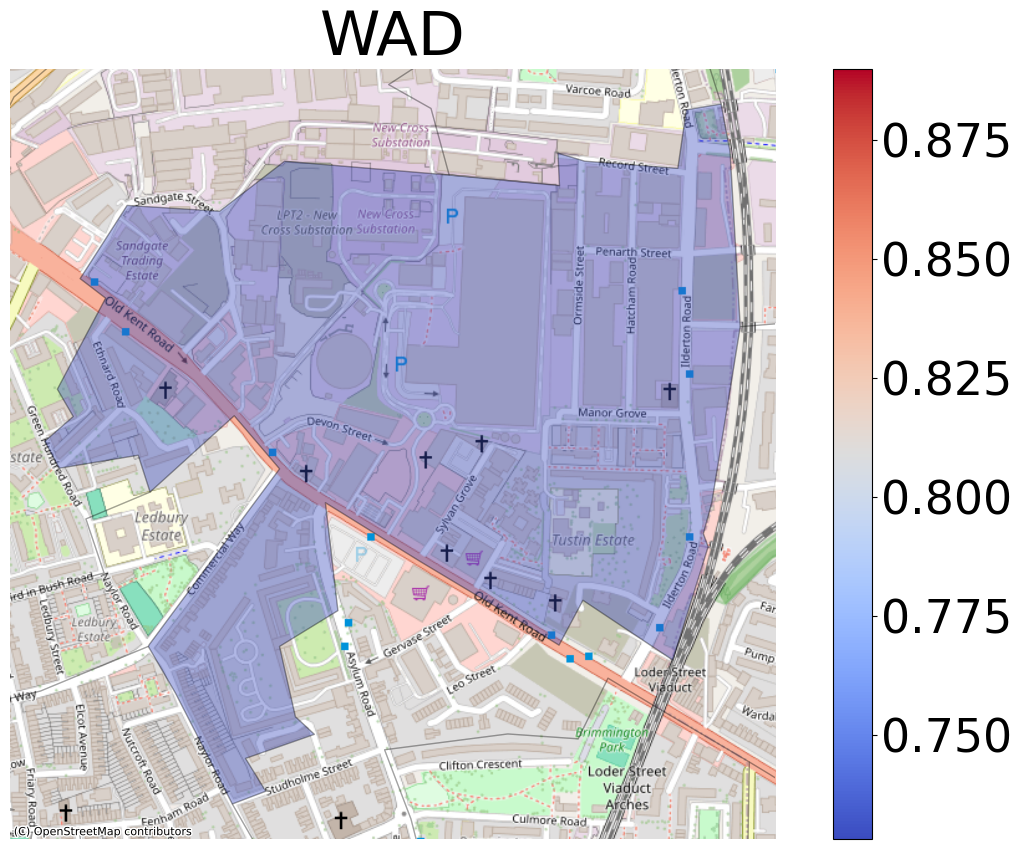

In [14]:
import pandas as pd
import geopandas as gpd
from shapely import wkt
from torch_geometric.explain import Explainer, GNNExplainer
from tqdm import tqdm
import matplotlib.pyplot as plt
import contextily as ctx
import matplotlib.colors as colors

# 自定义绘制函数
def plot_variable_v2(gdf, variable, variable_name, lsoas_gdf, alpha=0.4):
    if variable.startswith('e'):
        colormap = colors.LinearSegmentedColormap.from_list('', ['#ffffff', '#c27ba0'])
    elif variable.startswith('o'):
        colormap = colors.LinearSegmentedColormap.from_list('', ['#ffffff', '#6d9eeb'])
    elif variable.startswith('c'):
        colormap = colors.LinearSegmentedColormap.from_list('', ['#ffffff', '#008080'])
    else:
        colormap = 'coolwarm'

    # Parameters to display missing data in black
    missing_data_color = {
        'color': 'black',
        'label': 'Missing Data'
    }

    # Plotting the GeoPandas DataFrame with OpenStreetMap basemap
    fig, ax = plt.subplots(figsize=(15, 10))
    gdf.plot(column=variable, legend=True, cmap=colormap, missing_kwds=missing_data_color, ax=ax, alpha=alpha)

    # 添加OpenStreetMap底图
    ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

    # 绘制LSOA边界
    lsoas_gdf.boundary.plot(ax=ax, linewidth=1, edgecolor='black',alpha = 0.2, zorder=2)

    # Remove the axes
    plt.axis('off')

    # Customize the legend font size
    # Get the color bar object
    cax = plt.gcf().axes[-1]

    # Customize the color bar font size
    cax.tick_params(labelsize=33)

    # Title
    plt.title(variable_name, fontsize=44)

    plt.show()
# 创建包含WAD值的DataFrame
wad_df = pd.DataFrame(WAD_list, columns=['index', 'WAD'])

# 将WAD值与southwark_nodes连接
sub_gdf = southwark_nodes.merge(wad_df, left_index=True, right_on='index')

# 设置sub_gdf的坐标系为EPSG:27700（与原始坐标系一致）
sub_gdf.set_crs(epsg=27700, inplace=True)
# 转换为WGS84坐标系（EPSG:4326）
sub_gdf = sub_gdf.to_crs(epsg=4326)
# 转换为墨卡托投影以匹配OpenStreetMap
sub_gdf = sub_gdf.to_crs(epsg=3857)
# 确保sub_gdf和London_lsoas_2021的坐标系一致
assert sub_gdf.crs == London_lsoas_2021.crs, "CRS mismatch!"

# 可视化WAD值并叠加LSOA边界
plot_variable_v2(sub_gdf, 'WAD', 'WAD', London_lsoas_2021)

C:\Users\0\AppData\Local\Temp\ipykernel_18212\1464525311.py:102: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  sub_gdf.to_file(output_shapefile_path, driver='ESRI Shapefile')


Shapefile saved to sub_gdf_27700.shp


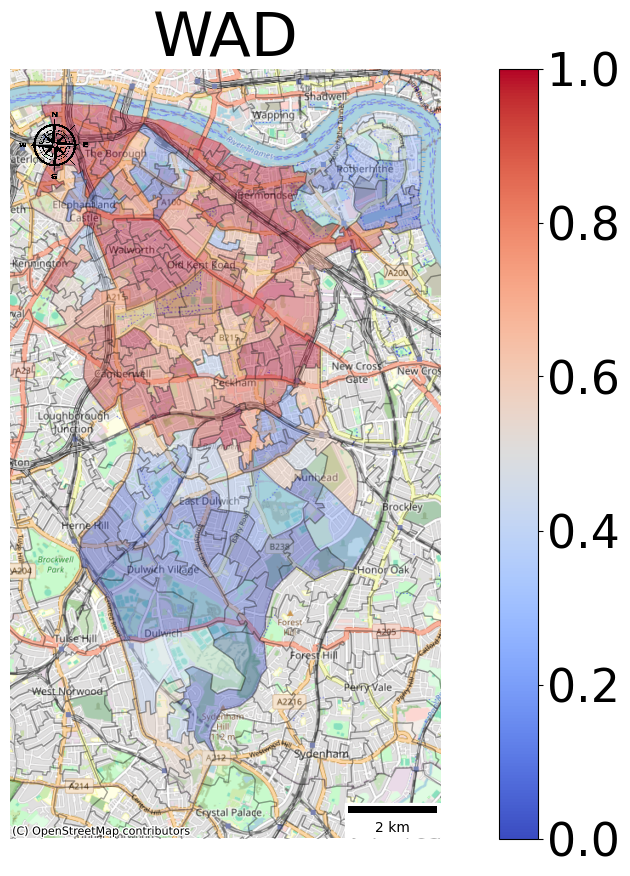

In [36]:
import matplotlib.transforms as transforms
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# 自定义绘制函数
def plot_variable_v2(gdf, variable, variable_name, lsoas_gdf, alpha=0.4, north_arrow_img_path='north arrow.png'):
    if variable.startswith('e'):
        colormap = colors.LinearSegmentedColormap.from_list('', ['#ffffff', '#c27ba0'])
    elif variable.startswith('o'):
        colormap = colors.LinearSegmentedColormap.from_list('', ['#ffffff', '#6d9eeb'])
    elif variable.startswith('c'):
        colormap = colors.LinearSegmentedColormap.from_list('', ['#ffffff', '#008080'])
    else:
        colormap = 'coolwarm'

    # Parameters to display missing data in black
    missing_data_color = {
        'color': 'black',
        'label': 'Missing Data'
    }

    # Plotting the GeoPandas DataFrame with OpenStreetMap basemap
    fig, ax = plt.subplots(figsize=(15, 10))
    gdf.plot(column=variable, legend=True, cmap=colormap, missing_kwds=missing_data_color, ax=ax, alpha=alpha)

    # 添加OpenStreetMap底图
    ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

    # 绘制LSOA边界
    lsoas_gdf.boundary.plot(ax=ax, linewidth=1, edgecolor='black', alpha=0.2, zorder=2)

    # Remove the axes
    plt.axis('off')

    # 添加比例尺
    scalebar = ScaleBar(dx=1, units='m', location='lower right', length_fraction=0.25, scale_loc='bottom')
    ax.add_artist(scalebar)

    # 添加指北针
    img = mpimg.imread(north_arrow_img_path)
    imagebox = OffsetImage(img, zoom=0.05)
    ab = AnnotationBbox(imagebox, (0.1, 0.9), xycoords='axes fraction', frameon=False)
    ax.add_artist(ab)

    # Customize the legend font size
    # Get the color bar object
    cax = plt.gcf().axes[-1]

    # Customize the color bar font size
    cax.tick_params(labelsize=33)

    # Title
    plt.title(variable_name, fontsize=44)

    plt.show()
# 创建包含WAD值的DataFrame
wad_df = pd.DataFrame(WAD_list, columns=['index', 'WAD'])

# 将WAD值与southwark_nodes连接
sub_gdf = southwark_nodes.merge(wad_df, left_index=True, right_on='index')

# 设置sub_gdf的坐标系为EPSG:27700（与原始坐标系一致）
sub_gdf.set_crs(epsg=27700, inplace=True)

def truncate_column_names(gdf, max_length=10):
    """
    Truncate GeoDataFrame column names to a specified maximum length and ensure uniqueness.
    
    Parameters:
    - gdf: The GeoDataFrame whose column names will be truncated.
    - max_length: Maximum length of the truncated column names (default is 10).
    
    Returns:
    - A GeoDataFrame with truncated column names.
    """
    new_columns = {}
    used_names = set()
    
    for col in gdf.columns:
        truncated_col = col[:max_length]
        # Ensure the truncated name is unique by appending a number if necessary
        if truncated_col in used_names:
            suffix = 1
            while f"{truncated_col[:max_length-1]}{suffix}" in used_names:
                suffix += 1
            truncated_col = f"{truncated_col[:max_length-1]}{suffix}"
        
        used_names.add(truncated_col)
        new_columns[col] = truncated_col
    
    return gdf.rename(columns=new_columns)

# 自动截断并重命名sub_gdf中的列名
sub_gdf = truncate_column_names(sub_gdf)

# 确保sub_gdf的坐标系为EPSG:27700
sub_gdf = sub_gdf.to_crs(epsg=27700)

# 保存sub_gdf为Shapefile
output_shapefile_path = 'sub_gdf_27700.shp'
sub_gdf.to_file(output_shapefile_path, driver='ESRI Shapefile')

print(f"Shapefile saved to {output_shapefile_path}")

# 转换为WGS84坐标系（EPSG:4326）
sub_gdf = sub_gdf.to_crs(epsg=4326)
# 转换为墨卡托投影以匹配OpenStreetMap
sub_gdf = sub_gdf.to_crs(epsg=3857)
# 确保sub_gdf和London_lsoas_2021的坐标系一致
assert sub_gdf.crs == London_lsoas_2021.crs, "CRS mismatch!"

# 可视化WAD值并叠加LSOA边界
plot_variable_v2(sub_gdf, 'WAD', 'WAD', London_lsoas_2021)

C:\Users\0\AppData\Local\Temp\ipykernel_18212\794980959.py:73: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  sub_gdf.to_file(output_shapefile_path, driver='ESRI Shapefile')


Shapefile saved to sub_gdf_27700.shp


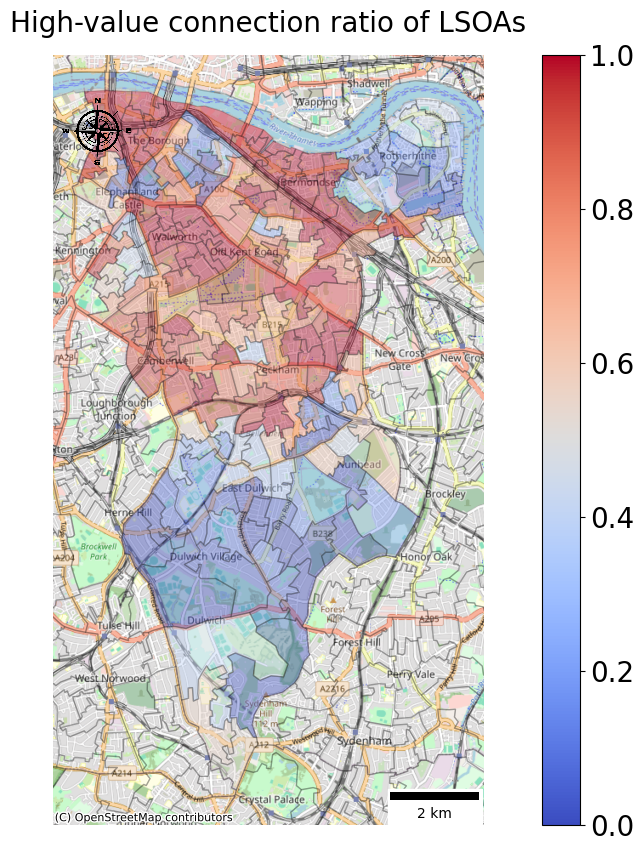

In [40]:
import matplotlib.transforms as transforms
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import os
# 自定义绘制函数
def plot_variable_v2(gdf, variable, variable_name, lsoas_gdf, alpha=0.4, north_arrow_img_path='north arrow.png'):
    if variable.startswith('e'):
        colormap = colors.LinearSegmentedColormap.from_list('', ['#ffffff', '#c27ba0'])
    elif variable.startswith('o'):
        colormap = colors.LinearSegmentedColormap.from_list('', ['#ffffff', '#6d9eeb'])
    elif variable.startswith('c'):
        colormap = colors.LinearSegmentedColormap.from_list('', ['#ffffff', '#008080'])
    else:
        colormap = 'coolwarm'

    # Parameters to display missing data in black
    missing_data_color = {
        'color': 'black',
        'label': 'Missing Data'
    }

    # Plotting the GeoPandas DataFrame with OpenStreetMap basemap
    fig, ax = plt.subplots(figsize=(15, 10))
    gdf.plot(column=variable, legend=True, cmap=colormap, missing_kwds=missing_data_color, ax=ax, alpha=alpha)

    # 添加OpenStreetMap底图
    ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

    # 绘制LSOA边界
    lsoas_gdf.boundary.plot(ax=ax, linewidth=1, edgecolor='black', alpha=0.2, zorder=2)

    # Remove the axes
    plt.axis('off')

    # 添加比例尺
    scalebar = ScaleBar(dx=1, units='m', location='lower right', length_fraction=0.25, scale_loc='bottom')
    ax.add_artist(scalebar)

    # 添加指北针
    img = mpimg.imread(north_arrow_img_path)
    imagebox = OffsetImage(img, zoom=0.05)
    ab = AnnotationBbox(imagebox, (0.1, 0.9), xycoords='axes fraction', frameon=False)
    ax.add_artist(ab)

    # Customize the legend font size
    # Get the color bar object
    cax = plt.gcf().axes[-1]

    # Customize the color bar font size
    cax.tick_params(labelsize=20)  # 将色条标识字体调小

    # Title
    plt.title("High-value connection ratio of LSOAs", fontsize=20)  # 修改标题并调整字体大小

    # 确保输出文件夹存在
    output_folder = '论文出图'
    os.makedirs(output_folder, exist_ok=True)
    
    # 保存绘图到输出文件夹
    output_path = os.path.join(output_folder, 'Southwark WAD.png')
    plt.savefig(output_path, bbox_inches='tight')

    plt.show()
# 自动截断并重命名sub_gdf中的列名
sub_gdf = truncate_column_names(sub_gdf)

# 确保sub_gdf的坐标系为EPSG:27700
sub_gdf = sub_gdf.to_crs(epsg=27700)

# 保存sub_gdf为Shapefile
output_shapefile_path = 'sub_gdf_27700.shp'
sub_gdf.to_file(output_shapefile_path, driver='ESRI Shapefile')

print(f"Shapefile saved to {output_shapefile_path}")

# 转换为WGS84坐标系（EPSG:4326）
sub_gdf = sub_gdf.to_crs(epsg=4326)
# 转换为墨卡托投影以匹配OpenStreetMap
sub_gdf = sub_gdf.to_crs(epsg=3857)
# 确保sub_gdf和London_lsoas_2021的坐标系一致
assert sub_gdf.crs == London_lsoas_2021.crs, "CRS mismatch!"

# 可视化WAD值并叠加LSOA边界
plot_variable_v2(sub_gdf, 'WAD', 'WAD', London_lsoas_2021)

In [2]:
import geopandas as gpd

# 读取保存的 Shapefile 文件
shapefile_path = 'sub_gdf_27700.shp'
gdf_sub = gpd.read_file(shapefile_path)

# 打印数据框架的字段（列名）
print("Fields (columns) in the shapefile:")
print(gdf_sub.columns)

# 如果需要，可以进一步查看数据框架的前几行数据
print("\nFirst few rows of the data:")
print(gdf_sub.head())

Fields (columns) in the shapefile:
Index(['LSOA21NM', 'c_net annu', 'o_diabetes', 'o_opioids_', 'o_OME_per_',
       'o_total_qu', 'o_hyperten', 'o_anxiety_', 'geo_centro', 'index', 'WAD',
       'geometry'],
      dtype='object')

First few rows of the data:
         LSOA21NM  c_net annu  o_diabetes  o_opioids_  o_OME_per_  o_total_qu  \
0  Southwark 020A     38000.0   30.205155   11.006891   95.272302    6.294713   
1  Southwark 019A     37300.0   21.750774    6.991260   57.796898    5.934004   
2  Southwark 024A     46600.0   12.905980    4.319285   36.398345    5.435657   
3  Southwark 024B     46600.0   23.147688    8.376164   73.544960    6.053855   
4  Southwark 024C     46600.0   20.682043    7.002295   59.233009    5.897402   

   o_hyperten  o_anxiety_                                    geo_centro  \
0   45.455248   21.324566   POINT (533045.296926902 176726.79275459188)   
1   31.748992   14.495106  POINT (533412.9115793356 176905.37009768424)   
2   19.096011    8.694403  P

In [4]:
import pandas as pd
import geopandas as gpd
from shapely import wkt
from torch_geometric.explain import Explainer, GNNExplainer
from tqdm import tqdm

# 读取CSV文件并创建GeoDataFrame
csv_file = 'LondonLSOAs.csv'
df = pd.read_csv(csv_file)

# 创建几何对象（假设geometry列包含WKT格式的多边形数据）
df['geometry'] = df['geometry'].apply(wkt.loads)
gdf = gpd.GeoDataFrame(df, geometry='geometry')

# 设置坐标系 (假设是WGS84坐标系)
gdf.set_crs(epsg=27700, inplace=True)
# 打印数据框架的字段（列名）
print("Fields (columns) in the shapefile:")
print(gdf.columns)

# 如果需要，可以进一步查看数据框架的前几行数据
print("\nFirst few rows of the data:")
print(gdf.head())

Fields (columns) in the shapefile:
Index(['LSOA21NM', 'centroid_x', 'centroid_y', 'c_percent asian',
       'c_percent black', 'c_percent mixed', 'c_percent white',
       'c_percent sikh', 'c_percent hindu', 'c_percent christian',
       ...
       'o_opioids_quantity_per_capita', 'o_OME_per_capita',
       'o_total_quantity_per_capita', 'o_asthma_quantity_per_capita',
       'o_hypertension_quantity_per_capita',
       'o_depression_quantity_per_capita', 'o_anxiety_quantity_per_capita',
       'geometry', 'geo_centroid', 'u_age_median'],
      dtype='object', length=169)

First few rows of the data:
                    LSOA21NM   centroid_x   centroid_y  c_percent asian  \
0        City of London 001A  532151.1942  181615.2014         0.107191   
1        City of London 001B  532443.6860  181645.7249         0.130592   
2        City of London 001C  532207.0148  182030.1296         0.094913   
3        City of London 001E  533618.3485  181157.3543         0.321526   
4  Barking and D

In [5]:
import pandas as pd
import geopandas as gpd

# 假设 gdf_sub 是已经读取的子数据集，gdf 是完整的数据集
# 读取 CSV 文件并创建 GeoDataFrame 的步骤已在之前完成

# 使用 LSOA21NM 字段进行配准，将完整数据集中 o_depression_quantity_per_capita 的值合并到子数据集
gdf_sub = gdf_sub.merge(gdf[['LSOA21NM', 'o_depression_quantity_per_capita']], 
                        on='LSOA21NM', how='left')

# 将 o_depression_quantity_per_capita 字段重命名为 DPRESS
gdf_sub.rename(columns={'o_depression_quantity_per_capita': 'DPRESS'}, inplace=True)

# 查看子数据集中是否成功添加并对齐字段
print("\nUpdated sub dataset:")
print(gdf_sub.head())



Updated sub dataset:
         LSOA21NM  c_net annu  o_diabetes  o_opioids_  o_OME_per_  o_total_qu  \
0  Southwark 020A     38000.0   30.205155   11.006891   95.272302    6.294713   
1  Southwark 019A     37300.0   21.750774    6.991260   57.796898    5.934004   
2  Southwark 024A     46600.0   12.905980    4.319285   36.398345    5.435657   
3  Southwark 024B     46600.0   23.147688    8.376164   73.544960    6.053855   
4  Southwark 024C     46600.0   20.682043    7.002295   59.233009    5.897402   

   o_hyperten  o_anxiety_                                    geo_centro  \
0   45.455248   21.324566   POINT (533045.296926902 176726.79275459188)   
1   31.748992   14.495106  POINT (533412.9115793356 176905.37009768424)   
2   19.096011    8.694403  POINT (532783.8780743518 176390.74744631368)   
3   34.986875   16.815728   POINT (533397.308139309 176512.54176974634)   
4   30.691143   14.146450   POINT (533133.284417942 176410.00255769797)   

   index       WAD                      

In [6]:
import geopandas as gpd

# 假设 gdf_sub 是更新后的 GeoDataFrame
# 定义保存路径
output_shapefile_path = 'updated_sub_gdf_27700.shp'

# 将更新后的子数据集保存为 Shapefile 文件
gdf_sub.to_file(output_shapefile_path, driver='ESRI Shapefile')

print(f"Updated Shapefile saved to {output_shapefile_path}")

Updated Shapefile saved to updated_sub_gdf_27700.shp


In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx

# 读取LSOA的shapefile并转换坐标系
fp = 'LSOA_(Dec_2021)_Boundaries_Generalised_Clipped_EW_(BGC).shp'
London_lsoas_2021 = gpd.read_file(fp).rename(columns={'LSOA21CD':'geography code'})
London_lsoas_2021 = London_lsoas_2021[London_lsoas_2021["geography code"].str.startswith("E")]

# 设置原始坐标系为EPSG:27700（英国国家格网）
London_lsoas_2021.set_crs(epsg=27700, inplace=True)
# 转换为WGS84坐标系（EPSG:4326）
London_lsoas_2021 = London_lsoas_2021.to_crs(epsg=4326)
# 转换为墨卡托投影以匹配OpenStreetMap
London_lsoas_2021 = London_lsoas_2021.to_crs(epsg=3857)

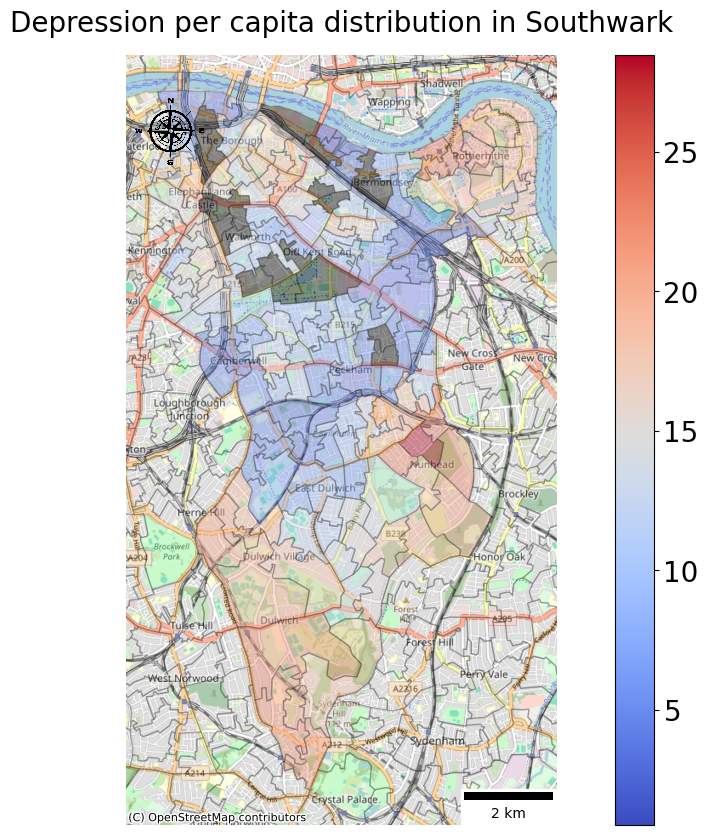

In [8]:
import geopandas as gpd
import os
import matplotlib.transforms as transforms
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import os
# 自定义绘制函数
def plot_variable_v2(gdf, variable, variable_name, lsoas_gdf, alpha=0.4, north_arrow_img_path='north arrow.png'):
    if variable.startswith('e'):
        colormap = colors.LinearSegmentedColormap.from_list('', ['#ffffff', '#c27ba0'])
    elif variable.startswith('o'):
        colormap = colors.LinearSegmentedColormap.from_list('', ['#ffffff', '#6d9eeb'])
    elif variable.startswith('c'):
        colormap = colors.LinearSegmentedColormap.from_list('', ['#ffffff', '#008080'])
    else:
        colormap = 'coolwarm'

    # Parameters to display missing data in black
    missing_data_color = {
        'color': 'black',
        'label': 'Missing Data'
    }

    # Plotting the GeoPandas DataFrame with OpenStreetMap basemap
    fig, ax = plt.subplots(figsize=(15, 10))
    gdf.plot(column=variable, legend=True, cmap=colormap, missing_kwds=missing_data_color, ax=ax, alpha=alpha)

    # 添加OpenStreetMap底图
    ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

    # 绘制LSOA边界
    lsoas_gdf.boundary.plot(ax=ax, linewidth=1, edgecolor='black', alpha=0.2, zorder=2)

    # Remove the axes
    plt.axis('off')

    # 添加比例尺
    scalebar = ScaleBar(dx=1, units='m', location='lower right', length_fraction=0.25, scale_loc='bottom')
    ax.add_artist(scalebar)

    # 添加指北针
    img = mpimg.imread(north_arrow_img_path)
    imagebox = OffsetImage(img, zoom=0.05)
    ab = AnnotationBbox(imagebox, (0.1, 0.9), xycoords='axes fraction', frameon=False)
    ax.add_artist(ab)

    # Customize the legend font size
    # Get the color bar object
    cax = plt.gcf().axes[-1]

    # Customize the color bar font size
    cax.tick_params(labelsize=20)  # 将色条标识字体调小

    # Title
    plt.title("Depression per capita distribution in Southwark", fontsize=20)  # 修改标题并调整字体大小

    # 确保输出文件夹存在
    output_folder = '论文出图'
    os.makedirs(output_folder, exist_ok=True)
    
    # 保存绘图到输出文件夹
    output_path = os.path.join(output_folder, 'Depression per capita distribution in Southwark.png')
    plt.savefig(output_path, bbox_inches='tight')

    plt.show()
# Read the shapefile as a GeoDataFrame
shapefile_path = 'updated_sub_gdf_27700.shp'
sub_gdf = gpd.read_file(shapefile_path)

# Ensure the GeoDataFrame is in the correct CRS (EPSG:27700)
sub_gdf = sub_gdf.to_crs(epsg=27700)

# Convert to WGS84 (EPSG:4326) and then to Mercator projection (EPSG:3857)
sub_gdf = sub_gdf.to_crs(epsg=4326)
sub_gdf = sub_gdf.to_crs(epsg=3857)

# Ensure the CRS of sub_gdf matches with London_lsoas_2021
assert sub_gdf.crs == London_lsoas_2021.crs, "CRS mismatch!"

# Visualize WAD values and overlay LSOA boundaries
plot_variable_v2(sub_gdf, 'DPRESS', 'DPRESS', London_lsoas_2021)


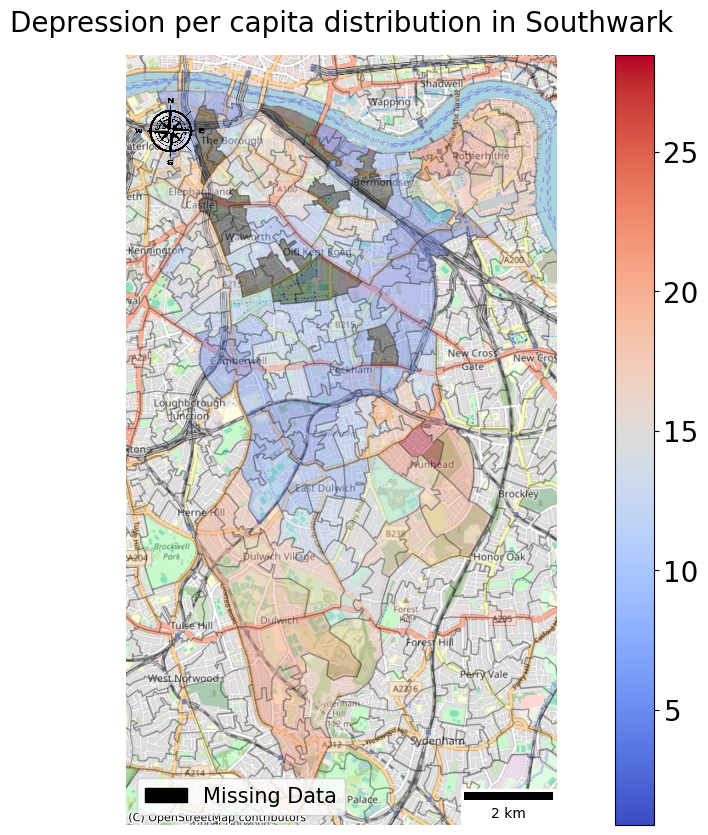

In [9]:
import geopandas as gpd
import os
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.patches import Patch
from matplotlib_scalebar.scalebar import ScaleBar
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# 自定义绘制函数
def plot_variable_v2(gdf, variable, variable_name, lsoas_gdf, alpha=0.4, north_arrow_img_path='north arrow.png'):
    if variable.startswith('e'):
        colormap = colors.LinearSegmentedColormap.from_list('', ['#ffffff', '#c27ba0'])
    elif variable.startswith('o'):
        colormap = colors.LinearSegmentedColormap.from_list('', ['#ffffff', '#6d9eeb'])
    elif variable.startswith('c'):
        colormap = colors.LinearSegmentedColormap.from_list('', ['#ffffff', '#008080'])
    else:
        colormap = 'coolwarm'

    # Parameters to display missing data in black
    missing_data_color = {
        'color': 'black',
        'label': 'Missing Data'
    }

    # Plotting the GeoPandas DataFrame with OpenStreetMap basemap
    fig, ax = plt.subplots(figsize=(15, 10))
    gdf.plot(column=variable, legend=True, cmap=colormap, missing_kwds=missing_data_color, ax=ax, alpha=alpha)

    # 添加OpenStreetMap底图
    ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

    # 绘制LSOA边界
    lsoas_gdf.boundary.plot(ax=ax, linewidth=1, edgecolor='black', alpha=0.2, zorder=2)

    # Remove the axes
    plt.axis('off')

    # 添加比例尺
    scalebar = ScaleBar(dx=1, units='m', location='lower right', length_fraction=0.25, scale_loc='bottom')
    ax.add_artist(scalebar)

    # 添加指北针
    img = mpimg.imread(north_arrow_img_path)
    imagebox = OffsetImage(img, zoom=0.05)
    ab = AnnotationBbox(imagebox, (0.1, 0.9), xycoords='axes fraction', frameon=False)
    ax.add_artist(ab)

    # Customize the legend font size
    # Get the color bar object
    cax = plt.gcf().axes[-1]

    # Customize the color bar font size
    cax.tick_params(labelsize=20)  # 将色条标识字体调大

    # Add a custom patch for missing data to the legend
    black_patch = Patch(color='black', label='Missing Data')
    ax.legend(handles=[black_patch], loc='lower left', fontsize=15)

    # Title
    plt.title("Depression per capita distribution in Southwark", fontsize=20)  # 修改标题并调整字体大小

    # 确保输出文件夹存在
    output_folder = '论文出图'
    os.makedirs(output_folder, exist_ok=True)
    
    # 保存绘图到输出文件夹
    output_path = os.path.join(output_folder, 'Depression per capita distribution in Southwark.png')
    plt.savefig(output_path, bbox_inches='tight')

    plt.show()

# Read the shapefile as a GeoDataFrame
shapefile_path = 'updated_sub_gdf_27700.shp'
sub_gdf = gpd.read_file(shapefile_path)

# Ensure the GeoDataFrame is in the correct CRS (EPSG:27700)
sub_gdf = sub_gdf.to_crs(epsg=27700)

# Convert to WGS84 (EPSG:4326) and then to Mercator projection (EPSG:3857)
sub_gdf = sub_gdf.to_crs(epsg=4326)
sub_gdf = sub_gdf.to_crs(epsg=3857)

# Ensure the CRS of sub_gdf matches with London_lsoas_2021
assert sub_gdf.crs == London_lsoas_2021.crs, "CRS mismatch!"

# Visualize DPRESS values and overlay LSOA boundaries
plot_variable_v2(sub_gdf, 'DPRESS', 'DPRESS', London_lsoas_2021)
